In [2]:
# importing the dependencies
import keras
import numpy as np
import itertools
import tensorflow as tf
from keras import backend as k
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
from IPython.display import clear_output
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import Dense,Flatten
from sklearn.metrics import confusion_matrix
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential ,Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense,Dropout
from keras.callbacks import ModelCheckpoint
from PIL import Image
import time
import os

Using TensorFlow backend.


In [3]:

# Install a Drive FUSE wrapper.

# https://github.com/astrada/google-drive-ocamlfuse

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Preparing to unpack .../04-gnupg_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg (2.1.15-1ubuntu8.1) over (2.1.15-1ubuntu8) ...
Preparing to unpack .../05-gnupg-agent_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg-agent (2.1.15-1ubuntu8

Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up gnupg-agent (2.1.15-1ubuntu8.1) ...
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:am

In [0]:
# Generate auth tokens for Colab

from google.colab import auth 
auth.authenticate_user()

In [5]:

# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()


import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive_1
!google-drive-ocamlfuse drive_1

In [0]:

from keras.preprocessing.image import ImageDataGenerator


gen = ImageDataGenerator(
    rescale = 1/.255,
    shear_range = .4,
     channel_shift_range = .5,
    zoom_range =.9,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    vertical_flip = True)

testgen = ImageDataGenerator(
    rescale = 1/.255)


In [89]:
# generate training and testing from the sepctogram images
X_train =[] 
X_test = []
y_train = []
y_test = []

genres = 0
genre_names = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
y = []

cur_time = time.time()
while genres<10:
    folder_name = genre_names[genres]
    images = os.listdir('drive_1/Colab Notebooks/images/' + folder_name)
    print('processing folder: ', folder_name)
    
    song_number = 0
    while song_number<90:
        path = 'drive_1/Colab Notebooks/images/'+folder_name+'/'+str(song_number)+'.png'
        img = cv2.imread(path)/255
        img= cv2.resize(img, (300,300))
        X_train.append(img)
        y_train.append(folder_name)
        song_number += 1
        
    while song_number>=90 and song_number<100:
        path = 'drive_1/Colab Notebooks/images/'+folder_name+'/'+str(song_number)+'.png'
        img = cv2.imread(path)/255
        img= cv2.resize(img, (300,300))
        X_test.append(img)
        y_test.append(folder_name)
        song_number += 1
     
    genres +=1
final_time = time.time()
time_taken = final_time - cur_time
print('time taken : ', time_taken/60)


processing folder:  blues
processing folder:  classical
processing folder:  country
processing folder:  disco
processing folder:  hiphop
processing folder:  jazz
processing folder:  metal
processing folder:  pop
processing folder:  reggae
processing folder:  rock
time taken :  4.036520528793335


In [0]:

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test= np.asarray(X_test)
y_test = np.asarray(y_test)

In [91]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 300, 300, 3)
(900,)
(100, 300, 300, 3)
(100,)


In [0]:
y_train = np.reshape(y_train, (900,1))
y_test = np.reshape(y_test, (100,1))

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

X_str =y_train
# transform to integer
X_int = LabelEncoder().fit_transform(X_str.ravel()).reshape(*X_str.shape)
# transform to binary
y_train = OneHotEncoder().fit_transform(X_int).toarray()



In [0]:

X_str =y_test
# transform to integer
X_int = LabelEncoder().fit_transform(X_str.ravel()).reshape(*X_str.shape)
# transform to binary
y_test = OneHotEncoder().fit_transform(X_int).toarray()


In [0]:
#plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [105]:
# model architecture
no_of_non_trainable_layers = 17

#no_of_non_trainable_layers = 0

base_model =keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(300,300,3), pooling=None)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

for layer in base_model.layers[:no_of_non_trainable_layers]:
    layer.trainable = False
for layer in base_model.layers[no_of_non_trainable_layers:]:
    layer.trainable = True


# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x =Dropout(.5)(x)
x = Dense(128, activation='relu')(x)
x =Dropout(.5)(x)

x = Dense(64, activation='relu')(x)
x =Dropout(.5)(x)

# and a logistic layer -- let's say we have 30 classes
predictions = Dense(10, activation='softmax')(x)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)


model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [0]:
# image data generator
gen = ImageDataGenerator(channel_shift_range=40, 
                         horizontal_flip= True,
                        vertical_flip = True)

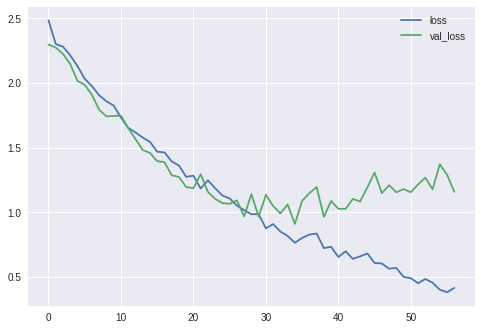


Epoch 00057: val_acc did not improve from 0.73000
Epoch 58/100
390/900 [============>.................] - ETA: 9s - loss: 0.3923 - acc: 0.8769 

KeyboardInterrupt: ignored

In [99]:
# training the model without data augmentation
filepath = 'drive_1/Colab Notebooks/best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(X_train,y_train,
         batch_size = 30,
          epochs  = 100,
         shuffle = True,
         validation_data = [X_test, y_test],
          callbacks = [plot_losses,checkpoint]
         )
'''
model.fit_generator(gen.flow(X_train,y_train,batch_size =30),
          verbose=1,
          steps_per_epoch = 700/30,
          epochs  = 100,
         shuffle = True,
         validation_data = [X_test, y_test],
          callbacks = [plot_losses,checkpoint])
'''

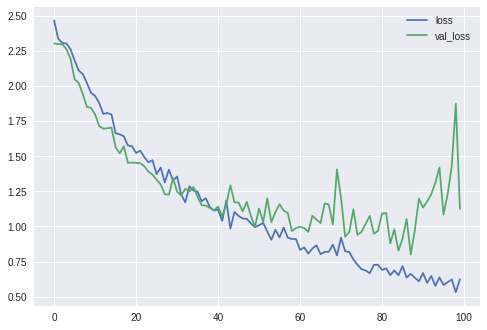


Epoch 00100: val_acc did not improve from 0.77000


In [102]:
# training the model with data augmentation
filepath = 'drive_1/Colab Notebooks/best_model_augmentation.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit_generator(gen.flow(X_train,y_train,batch_size =30),
          verbose=1,
          steps_per_epoch = 700/30,
          epochs  = 100,
         shuffle = True,
         validation_data = [X_test, y_test],
          callbacks = [plot_losses,checkpoint])

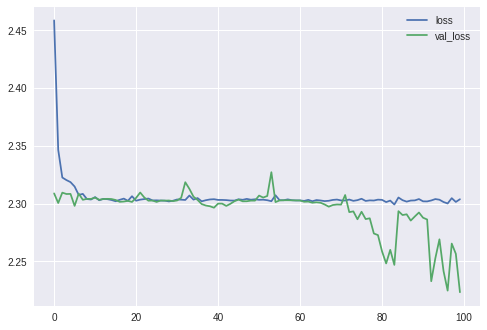


Epoch 00100: val_acc did not improve from 0.19000


In [106]:
# training the model with channel shift in data augmentation

filepath = 'drive_1/Colab Notebooks/best_model_aug_channel_shift.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit_generator(gen.flow(X_train,y_train,batch_size =30),
          verbose=1,
          steps_per_epoch = 700/30,
          epochs  = 100,
         shuffle = True,
         validation_data = [X_test, y_test],
          callbacks = [plot_losses,checkpoint])

In [0]:
# it can be seen that channel shift does not improve the performance

In [0]:
from keras.models import load_model
model = load_model('drive_1/Colab Notebooks/best_model.h5')

In [0]:
predicted = model.predict(X_test)

In [0]:
predicted = np.argmax(predicted ,axis = 1)

In [132]:
print(y_test)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [0]:
original = np.argmax(y_test, axis= 1)

In [134]:
print(original)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


Confusion matrix, without normalization
[[ 5  0  4  0  0  1  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0  8  1  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  1]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 1  0  2  0  0  7  0  0  0  0]
 [ 2  0  0  1  1  0  5  0  0  1]
 [ 0  0  0  0  0  0  0  9  1  0]
 [ 0  0  2  1  0  0  0  0  7  0]
 [ 2  1  3  0  0  0  0  0  0  4]]
Normalized confusion matrix
[[0.5 0.  0.4 0.  0.  0.1 0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.8 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.9 0.  0.  0.  0.  0.  0.1]
 [0.1 0.  0.  0.  0.9 0.  0.  0.  0.  0. ]
 [0.1 0.  0.2 0.  0.  0.7 0.  0.  0.  0. ]
 [0.2 0.  0.  0.1 0.1 0.  0.5 0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.9 0.1 0. ]
 [0.  0.  0.2 0.1 0.  0.  0.  0.  0.7 0. ]
 [0.2 0.1 0.3 0.  0.  0.  0.  0.  0.  0.4]]


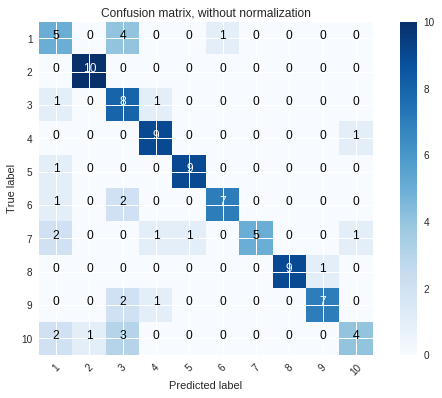

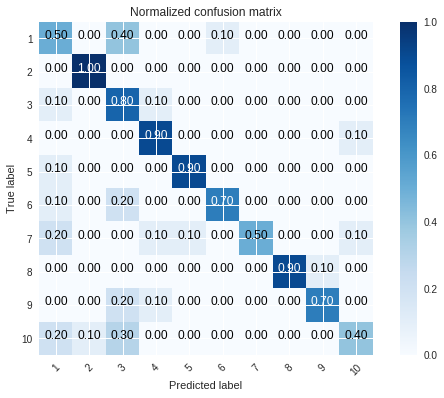

In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(original, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,10],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,10], normalize=True,
                      title='Normalized confusion matrix')

plt.show()